# Lateness

- berücksichtigt auch eine negative Abweichung, also wenn ein Job früher fertiggestellt wurde als geplant.

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import math
import pandas as pd
pd.set_option('display.max_rows', 21)

import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.utils.rolling_scheduling as rolling_schedule

import src.models.heuristics.fcfs as heuristics

import numpy as np
from ortools.sat.python import cp_model

import seaborn as sns
import matplotlib.pyplot as plt

import time

In [2]:
max_time = 60 * 45 # 45 min

In [3]:
basic_data_path = get_path("data", "basic")
df_instance = pd.read_csv(basic_data_path / "00_instance.csv")

df_jssp, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = 1, u_b_mmax= 0.94, shuffle = True)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
315,Job_031,5,M1,28
316,Job_031,6,M6,46
317,Job_031,7,M5,46
318,Job_031,8,M7,72


### a) Initialisierung der Deadlines

In [4]:
df_jobs = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, heuristics.schedule_fcfs_with_arrivals, target_service=1.0)
df_jobs

,Job,Arrival,Deadline
0,Job_000,0.00,1323.0
1,Job_001,81.32,1789.0
2,Job_002,101.67,2004.0
3,Job_003,142.01,2335.0
4,Job_004,177.21,1493.0
...,...,...,...
27,Job_027,1390.30,3195.0
28,Job_028,1391.02,2714.0
29,Job_029,1410.87,2727.0
30,Job_030,1423.44,2746.0


In [5]:
# Rundung für CP 
df_jobs["Arrival"] = np.floor(df_jobs["Arrival"]).astype(int)
df_jobs["Deadline"] = np.ceil(df_jobs["Deadline"]).astype(int)
df_jobs

,Job,Arrival,Deadline
0,Job_000,0,1323
1,Job_001,81,1789
2,Job_002,101,2004
3,Job_003,142,2335
4,Job_004,177,1493
...,...,...,...
27,Job_027,1390,3195
28,Job_028,1391,2714
29,Job_029,1410,2727
30,Job_030,1423,2746


### b) Bestimmung der "Ready Time"

In [6]:
df_jobs['Ready Time'] = ((df_jobs['Arrival'] // 1440) + 1) * 1440
df_jobs

,Job,Arrival,Deadline,Ready Time
0,Job_000,0,1323,1440
1,Job_001,81,1789,1440
2,Job_002,101,2004,1440
3,Job_003,142,2335,1440
4,Job_004,177,1493,1440
...,...,...,...,...
27,Job_027,1390,3195,1440
28,Job_028,1391,2714,1440
29,Job_029,1410,2727,1440
30,Job_030,1423,2746,1440


In [7]:
processing_time = df_jssp.groupby('Job')['Processing Time'].sum()
df_jobs = pd.merge(df_jobs, processing_time, on='Job')
df_jobs 

,Job,Arrival,Deadline,Ready Time,Processing Time
0,Job_000,0,1323,1440,395
1,Job_001,81,1789,1440,510
2,Job_002,101,2004,1440,568
3,Job_003,142,2335,1440,655
4,Job_004,177,1493,1440,393
...,...,...,...,...,...
27,Job_027,1390,3195,1440,539
28,Job_028,1391,2714,1440,395
29,Job_029,1410,2727,1440,393
30,Job_030,1423,2746,1440,395


### c) Bestimmung des Slacks
> mit "Ready Time" statt Arrival 

In [8]:
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])
df_jobs 

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1323,1440,395,-512
1,Job_001,81,1789,1440,510,-161
2,Job_002,101,2004,1440,568,-4
3,Job_003,142,2335,1440,655,240
4,Job_004,177,1493,1440,393,-340
...,...,...,...,...,...,...
27,Job_027,1390,3195,1440,539,1216
28,Job_028,1391,2714,1440,395,879
29,Job_029,1410,2727,1440,393,894
30,Job_030,1423,2746,1440,395,911


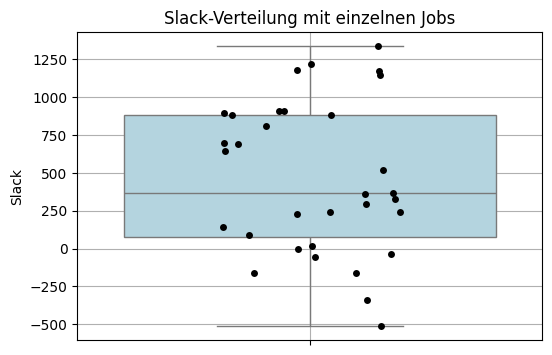

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_jobs['Slack'], color='lightblue')
sns.stripplot(y=df_jobs['Slack'], color='black', size=5, jitter=0.2)
plt.title('Slack-Verteilung mit einzelnen Jobs')
plt.ylabel('Slack')
plt.grid(True)
plt.show()


In [10]:
q25 = df_jobs['Slack'].quantile(0.25)
print("25%-Quantil (Q1) von Slack:", q25)


25%-Quantil (Q1) von Slack: 74.75


### d) Anpassung der Deadlines
> Addition des absoluten minimalen "negativen Slacks"

In [11]:
df_jobs['Slack'].min()

np.int64(-512)

In [12]:
abs(df_jobs['Slack'].min())

np.int64(512)

In [13]:
min_slack = df_jobs['Slack'].min()

if min_slack < 0:
    df_jobs["Deadline"] = df_jobs["Deadline"] + abs(min_slack) + 120
df_jobs

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1955,1440,395,-512
1,Job_001,81,2421,1440,510,-161
2,Job_002,101,2636,1440,568,-4
3,Job_003,142,2967,1440,655,240
4,Job_004,177,2125,1440,393,-340
...,...,...,...,...,...,...
27,Job_027,1390,3827,1440,539,1216
28,Job_028,1391,3346,1440,395,879
29,Job_029,1410,3359,1440,393,894
30,Job_030,1423,3378,1440,395,911


### e) erneute Bestimmung des Slacks

In [14]:
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])
df_jobs 

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1955,1440,395,120
1,Job_001,81,2421,1440,510,471
2,Job_002,101,2636,1440,568,628
3,Job_003,142,2967,1440,655,872
4,Job_004,177,2125,1440,393,292
...,...,...,...,...,...,...
27,Job_027,1390,3827,1440,539,1848
28,Job_028,1391,3346,1440,395,1511
29,Job_029,1410,3359,1440,393,1526
30,Job_030,1423,3378,1440,395,1543


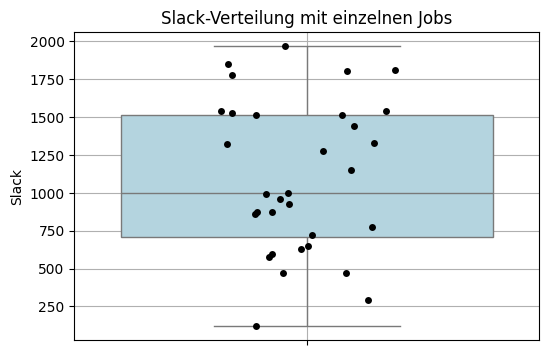

In [15]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_jobs['Slack'], color='lightblue')
sns.stripplot(y=df_jobs['Slack'], color='black', size=5, jitter=0.2)
plt.title('Slack-Verteilung mit einzelnen Jobs')
plt.ylabel('Slack')
plt.grid(True)
plt.show()


## A) Summe der absoluten Lateness je Job (letze Operation)

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).



In [16]:
from ortools.sat.python import cp_model
import pandas as pd

def solve_cp_jssp_sum_absolute_lateness(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    schedule_start: float = 0.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    from ortools.sat.python import cp_model
    import pandas as pd
    import math

    model = cp_model.CpModel()

    # Sortiere nach Deadline, falls gewünscht
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # Gruppiere Operationen je Job
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # Variablen definieren
    starts, ends, intervals = {}, {}, {}
    abs_lateness_vars = []

    for j, job in enumerate(jobs):
        seq = all_ops[j]
        for o, (op_id, m, d) in enumerate(seq):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # Lateness-Berechnung und Nebenbedingungen pro Job
    for j, job in enumerate(jobs):
        last_op = len(all_ops[j]) - 1
        job_end = ends[(j, last_op)]

        # Lateness kann positiv (zu spät) oder negativ (zu früh) sein
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        abs_lateness = model.NewIntVar(0, horizon, f"abs_lateness_{j}")
        model.Add(lateness == job_end - deadline[job])
        model.AddAbsEquality(abs_lateness, lateness)
        abs_lateness_vars.append(abs_lateness)

        # Startzeitbedingung (max von Arrival und schedule_start)
        model.Add(starts[(j, 0)] >= max(arrival[job], int(math.ceil(schedule_start))))

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # Maschinenrestriktionen
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (interval, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # Zielfunktion
    model.Minimize(sum(abs_lateness_vars))

    # Solver starten
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.max_time_in_seconds = timeLimit
    solver.parameters.relative_gap_limit = gapRel

    status = solver.Solve(model)

    # Lösung extrahieren (nur bei OPTIMAL oder FEASIBLE)
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness,
                    "Absolute Lateness": abs(lateness)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # Logging
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Summe Absolute Lateness : {solver.ObjectiveValue()}")
    print(f"Best Objective Bound    : {solver.BestObjectiveBound()}")
    print(f"Laufzeit                : {solver.WallTime():.2f} Sekunden")

    return df_schedule



In [17]:
starting_time = time.time()

# Scheduling
df_plan_sum_l = solve_cp_jssp_sum_absolute_lateness(df_jssp, df_jobs, msg=False, 
                                                    schedule_start = 1440,
                                                    timeLimit=max_time)

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan_sum_l


Solver-Status         : OPTIMAL
Summe Absolute Lateness : 73.0
Best Objective Bound    : 73.0
Laufzeit                : 397.61 Sekunden

Scheduling-Dauer: 6 Minuten und 37.65 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Absolute Lateness
0,Job_004,0,177,2125,M2,1441,14,1455,-670,670
1,Job_006,0,299,2325,M1,1441,46,1487,-838,838
2,Job_000,0,0,1955,M0,1452,29,1481,-474,474
3,Job_005,0,240,2534,M2,1455,84,1539,-995,995
4,Job_004,1,177,2125,M0,1481,6,1487,-638,638
...,...,...,...,...,...,...,...,...,...,...
315,Job_025,9,1252,3786,M4,3753,33,3786,0,0
316,Job_023,9,1211,3843,M8,3769,74,3843,0,0
317,Job_024,7,1238,4064,M3,3833,98,3931,-133,133
318,Job_024,8,1238,4064,M9,3931,22,3953,-111,111


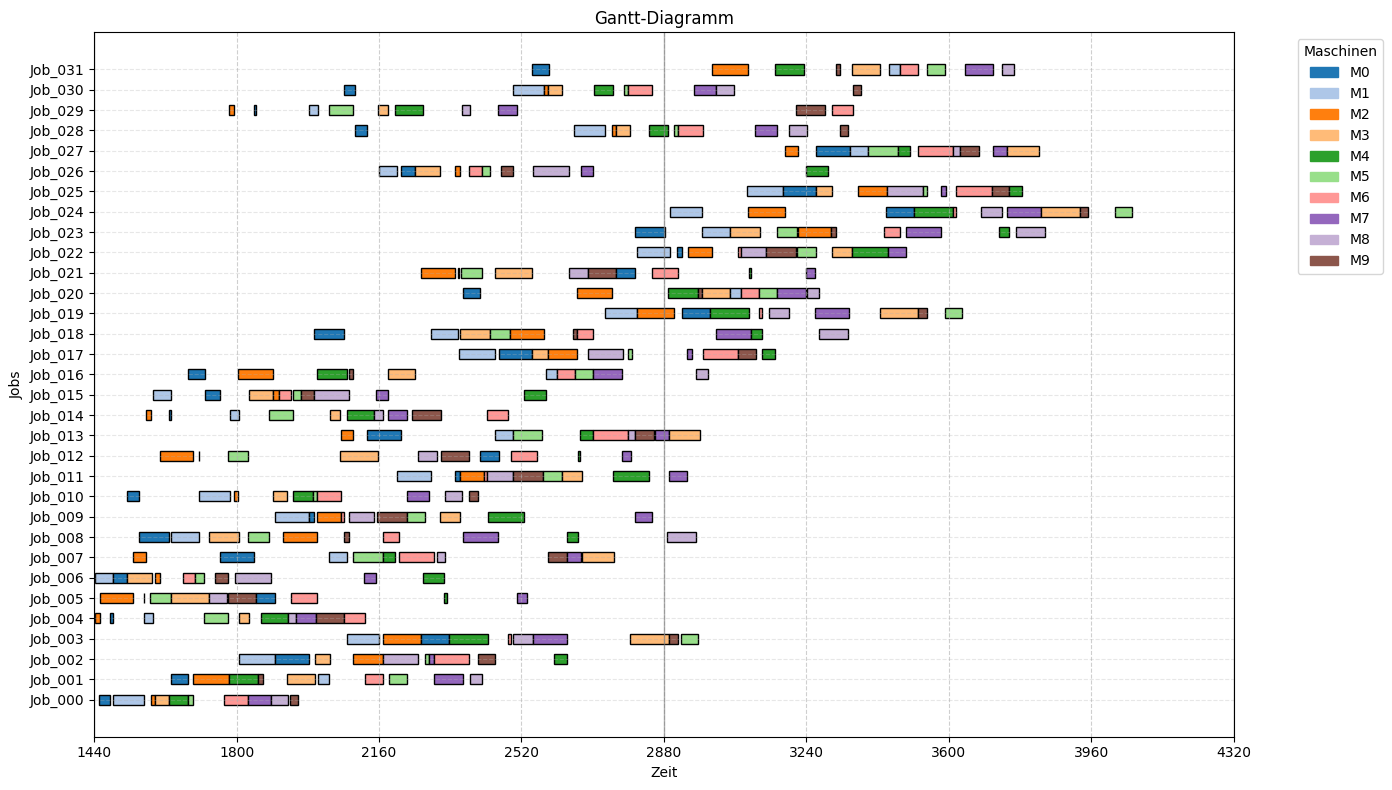

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [18]:
df_plan = df_plan_sum_l

show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [19]:
last_ops = df_plan_sum_l.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, 'Lateness', min_val = 0, max_val=60, steps=10)

label
<-60          0
-60 - -50     0
-50 - -40     0
-40 - -30     0
-30 - -20     0
-20 - -10     0
-10 - 0       0
0            30
0 - 10        0
10 - 20       0
20 - 30       0
30 - 40       1
40 - 50       1
50 - 60       0
>60           0
Name: count, dtype: int64

## B) Summe der Lateness minimieren (gewichtet Tardiness und Earliness)

### Zielfunktion

$$
\min \sum_{j \in J} \left( w_t \cdot \max(C_j - d_j,\ 0) + w_e \cdot \max(d_j - C_j,\ 0) \right)
$$


- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) des letzten Arbeitsschritts von Job $j$  
- $d_j$: Deadline (Soll-Endzeitpunkt) von Job $j$  
- $w_t$: Gewichtung der **Tardiness** (Verspätung)  
- $w_e$: Gewichtung der **Earliness** (Frühfertigkeit)  
- $\max(C_j - d_j,\ 0)$: positive Verspätung  
- $\max(d_j - C_j,\ 0)$: positive Frühfertigkeit  

### Erklärung

Diese Zielfunktion minimiert die gewichtete Summe aus **Tardiness** (Verspätung) und **Earliness** (Frühfertigkeit) aller Jobs.  
Dabei wird jede Abweichung zur Deadline einzeln bewertet:

- **Tardiness** wird mit $w_t$ gewichtet und tritt auf, wenn ein Job **nach** seiner Deadline fertig wird.
- **Earliness** wird mit $w_e$ gewichtet und tritt auf, wenn ein Job **vor** seiner Deadline fertig wird.

Durch die Wahl von $w_t \gg w_e$ kannst du **Verspätungen deutlich stärker bestrafen** als Frühfertigkeiten.



In [20]:
from ortools.sat.python import cp_model
import pandas as pd

def solve_cp_jssp_lateness_by_tardiness_and_earliness(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    schedule_start: float = 0.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    """
    Solves a Job-Shop Scheduling Problem (JSSP) using Constraint Programming with:
    - weighted tardiness (late completion),
    - weighted earliness (early completion),
    - optional global scheduling start time (schedule_start).

    Parameters:
        df_jssp: DataFrame with job-shop structure: ['Job','Operation','Machine','Processing Time']
        df_arrivals_deadlines: DataFrame with ['Job','Arrival','Deadline'] for each job
        w_t: Weight for tardiness penalty (default: 5)
        w_e: Weight for earliness penalty (default: 1)
        schedule_start: Earliest time from which operations may be scheduled (default: 0.0)
        sort_ascending: If True, jobs are sorted by deadline ascending (default: False)
        msg: Verbose solver output (default: False)
        timeLimit: Maximum solver time in seconds (default: 3600)
        gapRel: Acceptable relative gap for feasible solutions (default: 0.0)

    Returns:
        df_schedule: DataFrame with planned operations, start/end times, and lateness metrics.
    """
    from ortools.sat.python import cp_model
    import pandas as pd
    import math

    model = cp_model.CpModel()

    # Gewichte als ganze Zahlen für CP-Modell
    w_t = int(w_t)
    w_e = int(w_e)

    # === Vorbereitung: Jobliste, Ankunft, Deadlines ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Operationen je Job strukturieren und Maschinen erfassen ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Grobe obere Schranke für Planungshorizont ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Zeitvariablen und Intervalle anlegen ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Zielgrößen pro Job berechnen ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = tatsächliches Ende - Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness = max(0, Lateness)
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness = max(0, -Lateness)
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Startbedingung für erste Operation: max(Arrival, schedule_start)
        # Verhindert Einplanung vor Beginn des neuen Planungshorizonts
        model.Add(starts[(j, 0)] >= max(arrival[job], int(math.ceil(schedule_start))))

        # Technologische Reihenfolge: O_i+1 nach O_i
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # === Maschinenrestriktionen: keine Überlappung pro Maschine ===
    for m in machines:
        machine_intervals = [intervals[(j, o)][0] for (j, o), (iv, mach) in intervals.items() if mach == m]
        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion: gewichtete Summe aus Tardiness und Earliness minimieren ===
    model.Minimize(sum(weighted_terms))

    # === Solver konfigurieren ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # === Ergebnis extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Zusammenfassung der Lösung ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule


In [21]:
import time

starting_time = time.time()

# Aufruf der vereinfachten Zielfunktion: Tardiness und Earliness für die letzte Operation
df_plan = solve_cp_jssp_lateness_by_tardiness_and_earliness(
    df_jssp, df_jobs,
    w_t=5,      # Gewicht für Tardiness (Verspätung)
    schedule_start = 1440,
    msg=False,
    timeLimit=max_time,
    gapRel=0.01
)

ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")



Solver-Status         : OPTIMAL
Objective Value       : 74.00
Best Objective Bound  : 74.00
Laufzeit              : 694.84 Sekunden

Scheduling-Dauer: 11 Minuten und 34.97 Sekunden.


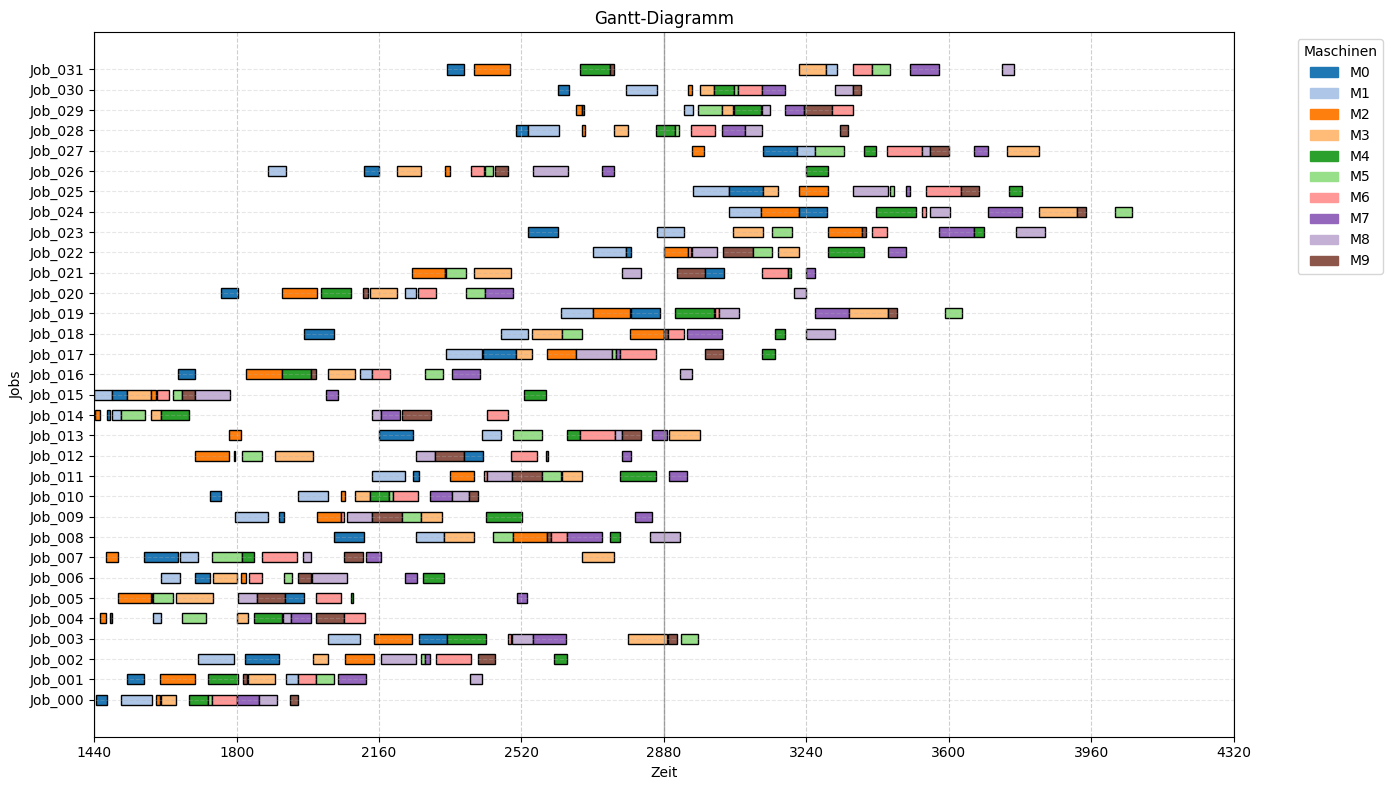

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [22]:
show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [23]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 90, steps= 30)

label
<-90          0
-90 - -60     0
-60 - -30     2
-30 - 0       1
0            29
0 - 30        0
30 - 60       0
60 - 90       0
>90           0
Name: count, dtype: int64